# Let's Begin

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from scipy.stats import norm
from scipy.optimize import linprog

from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u
import cmasher as cmr



import lmfit
from lmfit import minimize, Parameters,create_params,fit_report
from matplotlib.collections import LineCollection


from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [9]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.alpha = alpha
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + self.alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.2
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [10]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_cat_agg)):
        
        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha =1.

        if plot_cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 , alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] == 'N':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'U':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'F':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.8, 1.10, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [33]:
def lb_lv_plots_postcolor(Rings,out):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    #ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, alpha = {:.2f},red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha,out.redchi), fontsize=20, ha='right', va='top', 
    #        transform=ax[0].transAxes)
    
    ax[0].text(.98, 1.4, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha, out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    plt.show()

    return 

In [12]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/157986325.py:1: SyntaxWarning: invalid escape sequence '\s'
  def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):


In [13]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
'''def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y>y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y<=y_offset,y_NF,(Rings.y - np.nanmax(Rings.y[fore_ind]) )/ (np.nanmin(Rings.y[fore_ind]) - np.nanmax(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF
'''
def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>y_offset)
    fore_ind = np.where(Rings.y<=y_offset)

    y_NF =  Rings.y.copy()
    y_NF[back_ind] = -(Rings.y[back_ind] - y_offset )/ (Rings.y[back_ind].max() - y_offset)
    y_NF[fore_ind] = 1 - ((Rings.y[fore_ind] - np.nanmin(Rings.y[fore_ind]) )/ (y_offset-np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y>y_offset,y_NF,-(Rings.y - y_offset )/ (Rings.y[back_ind].max() - y_offset))
    #y_NF=np.where(Rings.y<=y_offset,y_NF,(Rings.y - np.nanmax(Rings.y[fore_ind]) )/ (np.nanmin(Rings.y[fore_ind]) - np.nanmax(Rings.y[fore_ind])))


    return back_ind, fore_ind, y_NF


def ring_NF_dist(Rings):
    back_ind = np.where(Rings.r>=8.2)
    fore_ind = np.where(Rings.r<8.2)

    y_NF =  Rings.r.copy()
    y_NF[back_ind] = -(Rings.r[back_ind] - 8.2 )/ (np.nanmax(Rings.r[back_ind]) - 8.2)
    y_NF[fore_ind] =  1-(Rings.r[fore_ind] - np.nanmin(Rings.r[fore_ind]) )/ (8.2 - np.nanmin(Rings.r[fore_ind]))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

def calculate_mahalanobis_distances(data, model):
    cov = np.cov(data.T) 
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data, model, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov


def min_distance_mahalanobis(data, model):

    # compute distances for every point on the stream
    dist, inv_cov = calculate_mahalanobis_distances(data, model)

    # find the minima 
    glob_min_idxs =[]
    for i in range(len(data)):
        glob_min_idxs.append(np.argwhere(dist[i]==np.min(dist[i])).ravel()[0])
    return glob_min_idxs, dist #returns all distance values and minima index

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -100., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index


#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

In [14]:
Rings_three = Ring(phi,
                  0.09 ,
                  0.055 ,
                  0.0125 ,
                  130 , 
                  np.radians(25 ),
                  xyzsun,vxyzsun,
                  0.4)

back_ind, fore_ind, y_NF=ring_NF_dist_y(Rings_three)
print(Rings_three.y.argmax(),y_NF.argmin(), Rings_three.y[Rings_three.y.argmax()], y_NF[Rings_three.y.argmax()])

print(Rings_three.y.argmin(), y_NF.argmax(),Rings_three.y[Rings_three.y.argmin()], y_NF[Rings_three.y.argmin()])

y_NF[fore_ind].max(), y_NF[back_ind].min()
#y_NF[np.where(Rings_three.y > 0.8*Rings_three.y.min())[0][0]]
#Rings_three.y[Rings_three.y.argmin()-100000], y_NF[Rings_three.y.argmin()-100000], y_offset

NameError: name 'phi' is not defined

In [15]:
def normedr_to_pc(r, A):
    '''takes in a normalized LOS position, r in (-1,1) scaling, 
    as well as a normalization constant A (in pc) that corresponds to the radius of the ellipse.
    returns top-down y value for distance from SgrA* in PARSECS
    
    y < 0 in NEAR, y>0 is FAR
    
    '''
    
    return A*r

# LMFIT time

In [127]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='13')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='14')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

#post_A = post_tab['A_MC']
#post_mu = post_tab['mu_MC']
#post_sigma = post_tab['sigma_MC']

post_A = post_tab['A']
post_mu = post_tab['mu']
post_sigma = post_tab['sigma']
post_CI68 = post_tab['CI68']


## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [119]:
cat_tab

<Table length=22>
leaf_id   cloud_name      l       b    ... NF_decision absorp_NF lb_pixel_mask
  str3      str14      float64 float64 ...     str3       str3       int64    
------- -------------- ------- ------- ... ----------- --------- -------------
      1 G359.475-0.044  -0.525  -0.044 ...          LN       nan             1
      2 G359.508-0.135  -0.492  -0.135 ...           N       nan             1
      3 G359.561-0.001  -0.439  -0.001 ...           U         F             1
     4a G359.595-0.223  -0.405  -0.223 ...           N       nan             1
      5 G359.608+0.018  -0.392   0.018 ...          LN         N             1
     6b G359.688-0.132  -0.312  -0.132 ...           U         F             1
     7a G359.701+0.032  -0.299   0.032 ...          LN         N             1
     8a G359.865+0.023  -0.135   0.023 ...           F         F             1
    11a   G0.014-0.016   0.014  -0.016 ...           F       nan             1
    ...            ...     ...     ... ...         ...       ...           ...
    17b    G0.255+0.02   0.255    0.02 ...           N         N             1
     18   G0.327-0.195   0.327  -0.195 ...           U       nan             1
     19    G0.342+0.06   0.342    0.06 ...           N         N             1
     20   G0.342-0.085   0.342  -0.085 ...           F         F             1
    21a    G0.379+0.05   0.379    0.05 ...           N         N             1
     22   G0.413+0.048   0.413   0.048 ...           N         N             1
     23   G0.488+0.008   0.488   0.008 ...           N         N             1
     24    G0.645+0.03   0.645    0.03 ...           N       nan             1
     25   G0.666-0.028   0.666  -0.028 ...           U         N             1
    26a    G0.716-0.09   0.716   -0.09 ...           N       nan             1

In [120]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_mu)

norml0.max(),normv0.max()

(np.float64(0.1443478260869564), np.float64(0.8999999999999999))

In [121]:
cat_tab

<Table length=22>
leaf_id   cloud_name      l       b    ... NF_decision absorp_NF lb_pixel_mask
  str3      str14      float64 float64 ...     str3       str3       int64    
------- -------------- ------- ------- ... ----------- --------- -------------
      1 G359.475-0.044  -0.525  -0.044 ...          LN       nan             1
      2 G359.508-0.135  -0.492  -0.135 ...           N       nan             1
      3 G359.561-0.001  -0.439  -0.001 ...           U         F             1
     4a G359.595-0.223  -0.405  -0.223 ...           N       nan             1
      5 G359.608+0.018  -0.392   0.018 ...          LN         N             1
     6b G359.688-0.132  -0.312  -0.132 ...           U         F             1
     7a G359.701+0.032  -0.299   0.032 ...          LN         N             1
     8a G359.865+0.023  -0.135   0.023 ...           F         F             1
    11a   G0.014-0.016   0.014  -0.016 ...           F       nan             1
    ...            ...     ...     ... ...         ...       ...           ...
    17b    G0.255+0.02   0.255    0.02 ...           N         N             1
     18   G0.327-0.195   0.327  -0.195 ...           U       nan             1
     19    G0.342+0.06   0.342    0.06 ...           N         N             1
     20   G0.342-0.085   0.342  -0.085 ...           F         F             1
    21a    G0.379+0.05   0.379    0.05 ...           N         N             1
     22   G0.413+0.048   0.413   0.048 ...           N         N             1
     23   G0.488+0.008   0.488   0.008 ...           N         N             1
     24    G0.645+0.03   0.645    0.03 ...           N       nan             1
     25   G0.666-0.028   0.666  -0.028 ...           U         N             1
    26a    G0.716-0.09   0.716   -0.09 ...           N       nan             1

In [122]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': 0, 'max': np.pi, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_OFF = create_params(a_rings={'value': 0.1   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 110.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 30  , 'min': 15, 'max': 360, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': 0, 'max': np.pi, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_dphi = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': True}
                          )



In [298]:
#############################
###Uncertainty of fitting?###
#############################
# Store the y-axis top-down values of all of the pc LOS distances 
# from each iteration of the fitting for each cloud.
# Then we'll make a histogram of the various distances for each cloud,
# and get the uncertainties in pc?

res = minimize(ring_resid, method='emcee', nan_policy='omit', args=(Ndata.l0,Ndata.b0,Ndata.v0), burn=300, steps=1000, thin=20,
                     params=params, is_weighted=False, progress=True)

0.09 0.055 0.0125 0.6111111111111112
0.13981264581029934 0.4892406425687187 0.9607947440113154 0.8301947551723227 0.05681329601284947 0.6290532883790181
2.282996671130876

0.08999032798402501 0.05499897835523263 0.012500899108344815 0.6111654395236341
emcee: Exception while calling your likelihood function:
  params: [8.99903280e-02 5.49989784e-02 1.25008991e-02 1.30002330e+02
 2.49991582e+01 4.00036549e-01 9.99996097e-03]
  args: (<function ring_resid at 0x1987ad260>, Parameters([('a_rings', <Parameter 'a_rings', value=np.float64(0.08999032798402501), bounds=[0.01:0.3]>), ('b_rings', <Parameter 'b_rings', value=np.float64(0.05499897835523263), bounds=[0.01:0.2]>), ('z_rings', <Parameter 'z_rings', value=np.float64(0.012500899108344815), bounds=[0.0:0.05]>), ('v_rings', <Parameter 'v_rings', value=np.float64(130.00232984089877), bounds=[100.0:150.0]>), ('theta_rings', <Parameter 'theta_rings', value=np.float64(24.99915818745133), bounds=[0:180]>), ('alpha_rings', <Parameter 'alpha_ring

Traceback (most recent call last):
  File "/opt/anaconda3/envs/python3_13/lib/python3.13/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/python3_13/lib/python3.13/site-packages/lmfit/minimizer.py", line 1086, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_17734/2598658821.py", line 20, in ring_resid
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
  File "/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_17734/2870402379.py", line 60, in __init__
    self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
                                                   ~~~~~~~^
        self.x,self.y,self.z,self.vx,self.vy,self.vz,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        xyzsun[0],xyzsun[1],xyzsun[2],vxy

KeyboardInterrupt: 

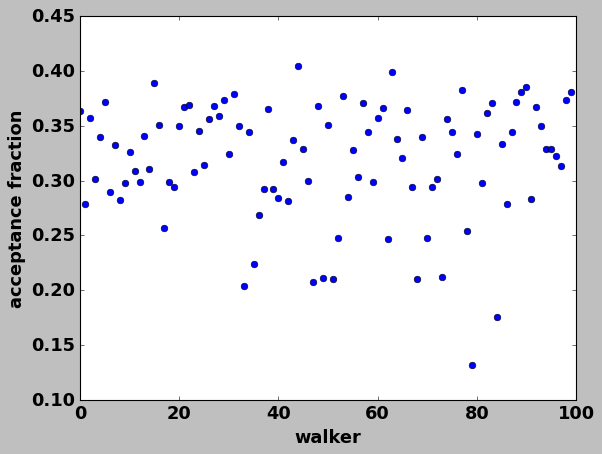

In [ ]:
plt.plot(res.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

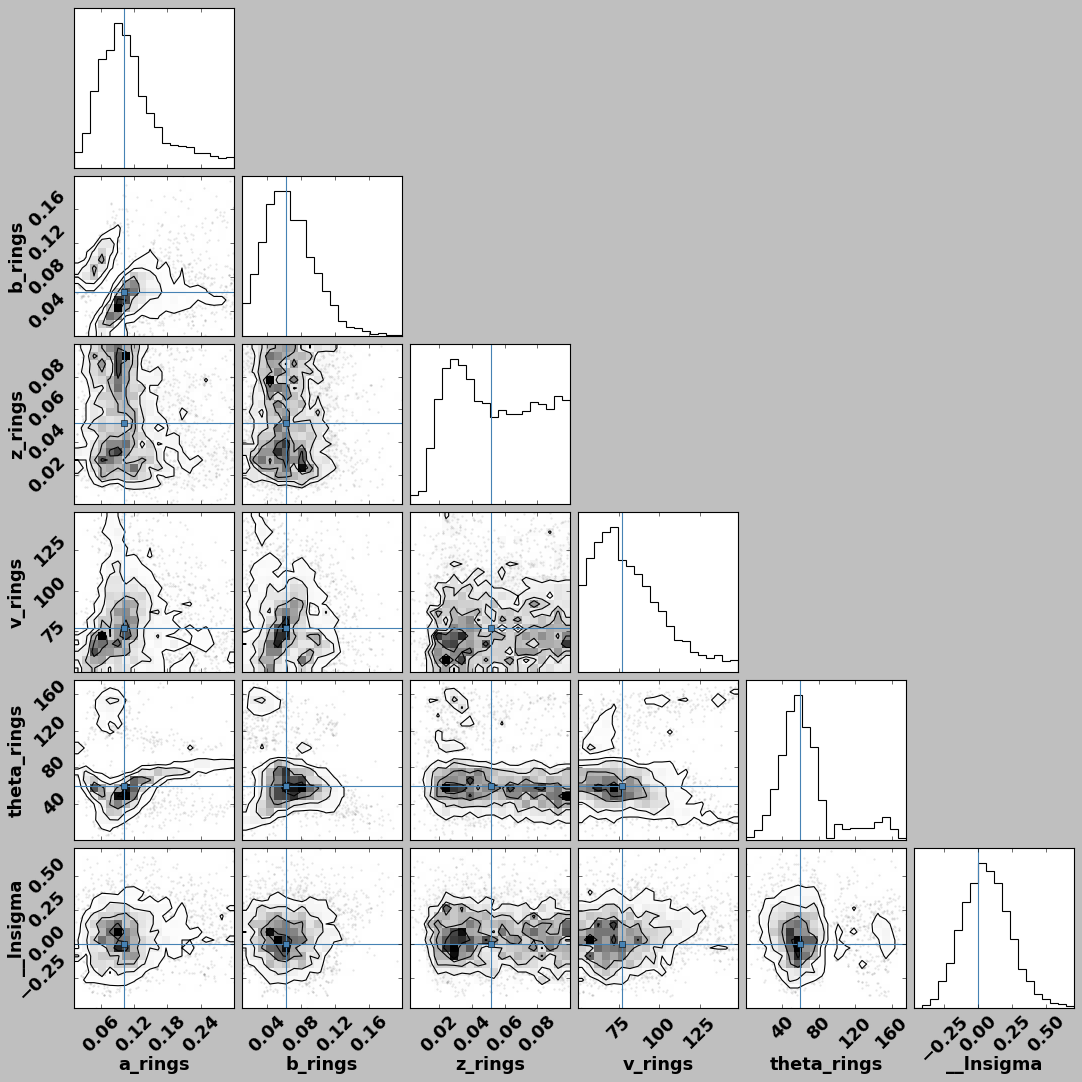

In [ ]:
import corner

emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values())[0:-1])

# Set up the Residual Function

In [123]:
def wasserstein(latitude_ellipse, mass_ellipse, latitude_prior, mass_prior):
    """Computes the Wasserstein-1 Metric (Earth-Mover's Distance)
    by solving an exact optimal-transport problem.

    Args:
        latitude_ellipse: An (n,) numpy float array containing normalized
                          latitudes of points sampled around the ellipse.
                          Should be in dimensionless units, normalized by some
                          b_0 in units angle to ensure output w_metric
                          is also dimensionless.
        mass_ellipse: An (n,) numpy float array containing normalized
                      masses of the same point sampling over the ellipse.
                      Should sum to 1.
        latitude_prior: An (n,) numpy float array containing normalized latitudes
                        sampled appropriately over a total latitude extent.
                        Should be in dimensionless units, normalized by some
                        b_0 in units angle to ensure output w_metric
                        is also dimensionless.
        mass_prior: An (n,) numpy float array containing normalized masses of
                    the same point sampling over the prior mass distribution.
                    Should sum to 1.

    Returns:
        w_metric: The normalized (dimensionless) Wasserstein-1 Metric.

    Raises:
        RuntimeError: If scipy.optimize.linprog fails.
    """
    n = latitude_ellipse.size
    cost_fn = lambda x, y: np.abs(x - y)
    cost = cost_fn(latitude_ellipse[:, None], latitude_prior[None, :])
    # mass_conservation_matrix * optimal_transport_matrix = [mass_ellipse; mass_prior]
    mass_conservation_matrix = np.zeros((2 * n, n * n))
    for i in range(n):
        mass_conservation_matrix[i, i * n:(i + 1) * n] = 1.0                  # row sums = mass_ellipse
        mass_conservation_matrix[n + i, i::n] = 1.0                           # col sums = mass_prior
    mass = np.concatenate([mass_ellipse, mass_prior])
    result = linprog(cost.ravel(), A_eq=mass_conservation_matrix, b_eq=mass, bounds=(0, None), method='highs')
    if not result.success:
        raise RuntimeError(f'scipy.optimize.linprog failed: {result.message}')
    optimal_transport_matrix = result.x.reshape(n, n)
    w_list = optimal_transport_matrix * cost
    w_metric = (optimal_transport_matrix * cost).sum()
    return w_metric,w_list

In [ ]:
from scipy.stats import wasserstein_distance_nd
a_rings=params['a_rings']
b_rings=params['b_rings']
z_rings=params['z_rings']
v_rings=params['v_rings']
theta_rings=params['theta_rings']
alpha_rings=params['alpha_rings']
ddphi=params['ddphi']


dphi = np.radians(ddphi)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
        
### Pre-process the given MODEL; normalize to [-1,1] ###
normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

data_l0_arr = Ndata.l0.value
data_b0_arr = Ndata.b0.value
data_mass_prior = cat_tab['mass_msun'].value/np.sum(cat_tab['mass_msun'].value) #normed to sum to 1
ellipse_b0_sample = np.linspace(Nrings.b0.min(), Nrings.b0.max(), len(data_mass_prior)) #even sampling of normed ellipse latitude pts 
ellipse_l0_sample = np.linspace(Nrings.l0.min(), Nrings.l0.max(), len(data_mass_prior)) #even sampling of normed ellipse latitude pts 
ellipse_mass_prior = np.full(data_mass_prior.shape, 1./len(data_mass_prior)) #uniform distribution of mass on the ellipse pts to start

wasserstein_distance_nd()



NameError: name 'Nrings' is not defined

In [ ]:
def ring_resid(params, l,b,v):
    
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    alpha_rings=params['alpha_rings']
    ddphi=params['ddphi']

    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun,alpha_rings)
            
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

    ### Sample the data and rings to assign total mass for the Wasserstein metric calc###
    data_l0_arr = Ndata.l0.value
    data_b0_arr = Ndata.b0.value
    data_mass_prior = cat_tab['mass_msun'].value/np.sum(cat_tab['mass_msun'].value) #normed to sum to 1
    ellipse_b0_sample = np.linspace(Nrings.b0.min(), Nrings.b0.max(), len(data_mass_prior)) #even sampling of normed ellipse latitude pts 
    ellipse_l0_sample = np.linspace(Nrings.l0.min(), Nrings.l0.max(), len(data_mass_prior)) #even sampling of normed ellipse latitude pts 
    ellipse_mass_prior = np.full(data_mass_prior.shape, 1./len(data_mass_prior)) #uniform distribution of mass on the ellipse pts to start

    w_metric_l,w_list_l = wasserstein(ellipse_l0_sample,ellipse_mass_prior,data_l0_arr,data_mass_prior) #sum of total work for optimal mass movement
    w_metric_b,w_list_b = wasserstein(ellipse_b0_sample,ellipse_mass_prior,data_b0_arr,data_mass_prior) #sum of total work for optimal mass movement

    w_metric = np.sqrt(w_metric_b**2) 

    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=int(np.sqrt(len(Nrings.l0))), metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data_lbv = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data_lbv = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs_lbv, dist_lbv = min_distance_mahalanobis(cat_data_lbv,model_data_lbv)

    model_data_lb = np.vstack([Nrings.l0,Nrings.b0]).T
    cat_data_lb = np.vstack([Ndata.l0,Ndata.b0]).T
    glob_min_idxs_lb, dist_lb = min_distance_mahalanobis(cat_data_lb,model_data_lb)

    cat_los_i = [] #list for values of LOS in parsec for each cloud
    
    for i in range(len(cat_data_lbv)):

        ### store min distance into the min dist list ###
        min_d_lbv = (dist_lbv[i][glob_min_idxs_lbv[i]]) 
        min_d_lb = (dist_lb[i][glob_min_idxs_lb[i]]) 
        min_d_list.append(min_d_lbv)
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        common_nf = Counter(neighbors_nf).most_common(1)[0][0]


        #post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])

        area_between = abs(norm.cdf(common_nf, loc=post_mu[i], scale=post_CI68[i]/2 )- 0.5)

       
        #area_between = abs(post_A[i] - post_dist_value) #this fits by comparing how offset the point is from the center of the gaussian
        nf_penalty = area_between#*(1+post_sigma[i])
        nf_penalty = area_between
        nf_penalty_list.append(nf_penalty)



    optimal_dist_list = np.sqrt(np.array(min_d_list)**2 + w_metric**2)
    resid_list = np.array(optimal_dist_list) + np.array(nf_penalty_list)

    #resid_list = [((0.75*(x)) + (0.25*w_metric))  for x in optimal_dist_list]


    redchi = np.sum([x**2 for x in resid_list])/(22-6)
    
    if a_rings.value<b_rings.value:
        print('XXXXX', a_rings.value,b_rings.value, z_rings.value, b_rings.value/a_rings.value, w_metric,redchi)
    else:
        print(a_rings.value,b_rings.value, z_rings.value,v_rings.value,theta_rings.value,alpha_rings.value,w_metric,redchi)
        

    return resid_list
    

In [508]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       #b_rings={'value': 0.155  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': -180, 'max': 180, 'vary': True},
                       alpha_rings={'value': 0.4  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )
params.add('b_rings', value=0.61*params['a_rings'].value, min=0.01, max=0.2, vary=True)
#params.add('alpha_rings', value=0.3904+(((params['a_rings'].value-0.010)/0.005)*0.0006), min= -np.pi/2, max= np.pi/2, vary=True)

#params.add('b_rings', value=0.055, min=0.01, max=0.2, vary=True)

out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))



0.09000000000000001 0.05489999999999999 0.0125 130.0 25.0 0.40000000000000013 0.08846800304344941 2.3149828663178056
0.08700534720762094 0.05489999999999999 0.0125 130.0 25.0 0.40000000000000013 0.08845707562296709 2.3978439824824704
0.09000000000000001 0.05489999999999999 0.01193753588210128 130.0 25.0 0.40000000000000013 0.08744680396836771 2.3271796006854997
0.09000000000000001 0.05489999999999999 0.0125 130.24635451043287 25.0 0.40000000000000013 0.08846800304344941 2.3179360845444856
0.09000000000000001 0.05489999999999999 0.0125 130.0 26.24128296079965 0.40000000000000013 0.08848290314796459 2.246094940778731
0.09000000000000001 0.05489999999999999 0.0125 130.0 25.0 0.4195223600830269 0.08846404493876395 2.3187082006103834
0.09000000000000001 0.052677738051419815 0.0125 130.0 25.0 0.40000000000000013 0.0884661593436848 2.2204337256424487
0.0930297629356444 0.05415486659954179 0.012311540925982401 130.08217571639815 25.41389879246003 0.40651497969937367 0.08805173258367156 2.17860

In [503]:
out.residual

array([0.86818472, 0.45473884, 1.15321372, 1.61370471, 1.19859519,
       0.9680633 , 1.1092165 , 0.67045334, 1.39196921, 1.91021657,
       0.83805286, 0.99168213, 1.04257879, 1.08639384, 0.75217567,
       1.1331877 , 0.79129607, 0.98070065, 0.85966291, 1.35881061,
       1.00602629, 1.23918029])

In [504]:
np.sqrt(len(Rings_out.l))

np.float64(600.0)

In [509]:
out


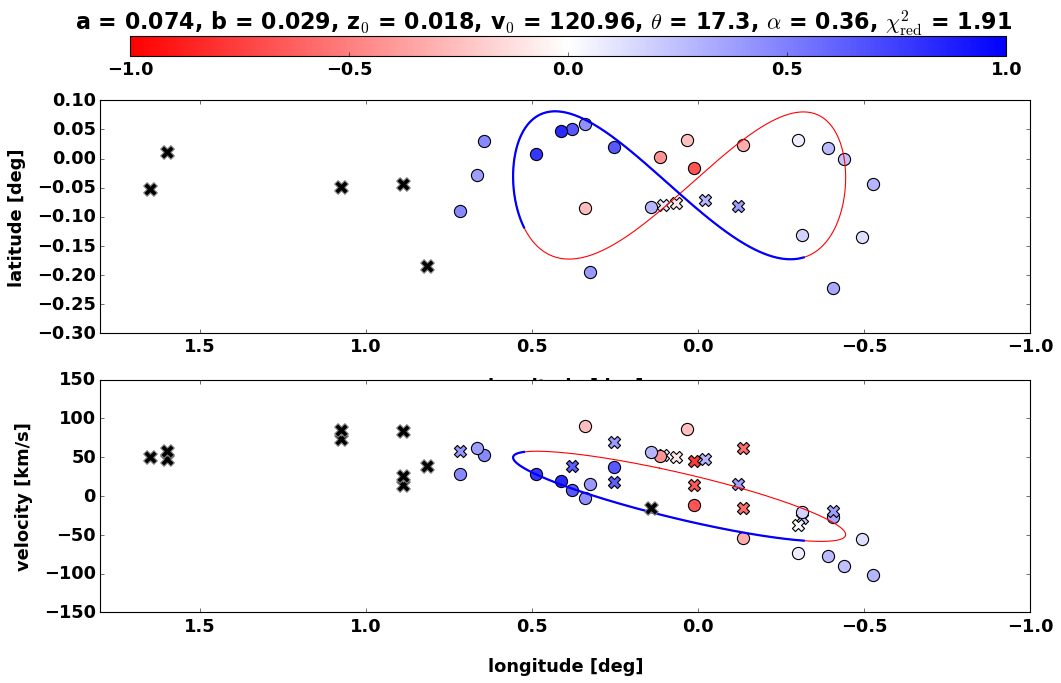

In [510]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun,
                  out.params['alpha_rings'].value)

Rings_out_redo = Ring(phi,
                  0.135 ,
                  0.092 ,
                  0.016 ,
                  128.1 , 
                  np.radians(22.9 ),
                  xyzsun,vxyzsun,
                  0.116)

"""

Rings_out_avg = Ring(phi,
                  0.155 ,
                  0.117 ,
                  0.016 ,
                  129.8 , 
                  np.radians(33.8 ),
                  xyzsun,vxyzsun,)




Rings_out = Ring(phi,
                  0.136,
                  0.103,
                  0.013,
                  130.6, 
                  np.radians(40.2),
                  xyzsun,vxyzsun)
"""
'''
Rings_out_off = Ring(phi,
                  out_off.params['a_rings'].value,
                  out_off.params['b_rings'].value,
                  out_off.params['z_rings'].value,
                  out_off.params['v_rings'].value, 
                  np.radians(out_off.params['theta_rings'].value),
                  xyzsun,vxyzsun)'''

lb_lv_plots_postcolor(Rings_out, out)
#lb_lv_plots_postcolor(Rings_out_off, out_off)

#Save output to dat files
list(vars(Rings_out).items())

save_Rings_out = Table()
Rings_out_fit_params = Table()

for i in list(vars(Rings_out).items()):
    if i[0] in ['x', 'y', 'z', 'R', 'phi', 'v', 'vx', 'vy', 'vz', 'l', 'b', 'r', 'vl', 'vb', 'vr' ]:
        save_Rings_out[i[0]] = i[1]
    if i[0] in ['a','bb','z0','v0','theta']:
        Rings_out_fit_params[i[0]] = [i[1]]
        
#ascii.write(save_Rings_out, "/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out.dat", overwrite=True)  
#ascii.write(Rings_out_fit_params,"/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out_params.dat", overwrite=True)


In [462]:
for i in list(vars(Rings_out).items()):
    if i[0] in ['a','bb','z0','v0','theta']:
        print(i)

('a', np.float64(0.15516497895016534))
('bb', np.float64(0.06848762794311379))
('z0', np.float64(0.020295150196549663))
('v0', np.float64(75.09998268612964))
('theta', np.float64(1.2401067694896015))


# Bold Line Plots

In [193]:
#scouse data for LV 
scouse_fits = pd.read_csv('../CMZ_datasets/final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/3215178084.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+")


In [194]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [199]:
def lb_lv_plots_postcolor_grad(Rings, out='None', scouse_on='None', output_save = 'None'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag


    ### Plot Rings LB ###
    sgra = ax[0].scatter(-0.0558, -0.0462,marker = '*', s=150 ,color = 'k',zorder=10)
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)

    if scouse_on == True:
        l   = scouse_fits['l'].values
        b   = scouse_fits['b'].values
        v   = scouse_fits['velocity'].values
        amp = scouse_fits['amp'].values

        #ax[0].scatter(l, b, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
        #        norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)
        ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',
                norm=mpl.colors.LogNorm(), alpha=0.1, zorder=0)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)  
    if out =='None':
        ax[0].text(.9, 1.4, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)

    else:  
        ax[0].text(.9, 1.4, r'a = %.3f, b = %.3f, z$_{0}$ = %.3f, v$_{0}$ = %.2f, $\theta$ = %.1f, $\alpha$ = %.2f, $\chi^{2}_{\mathrm{red}}$ = %.2f' %(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),Rings.alpha, out.redchi), fontsize=20, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    #cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    #cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    #cb2.set_label('Ring LOS N/F', rotation=270)

    if output_save != 'None':
        plt.savefig(output_save, bbox_inches='tight')   
    
    plt.show()





/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/584693955.py:88: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax[1].scatter(l, v, c=amp, cmap='Blues', marker='o', s=1, facecolor='1',


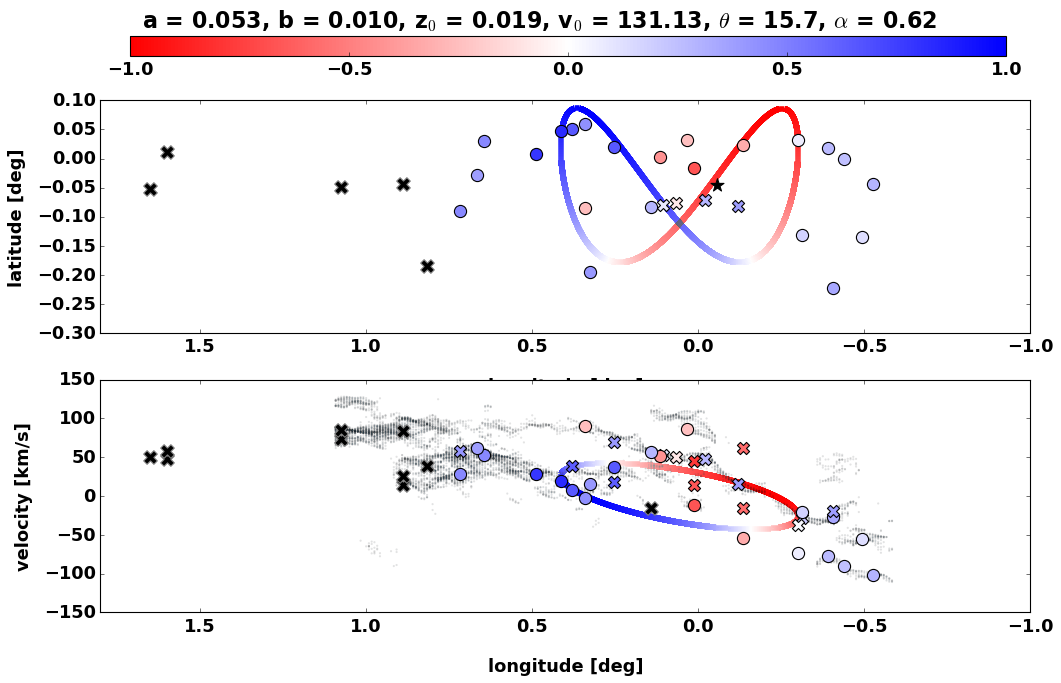

In [200]:

lb_lv_plots_postcolor_grad(Rings_out, scouse_on=True, output_save='./paper_items/Figs/paper3_ellipse_fit_output.png')
#lb_lv_plots_postcolor_grad(Rings_out_off, out_off)


# Top-down visualizations!

In [380]:
def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Negative values are on the NEAR SIDE in front of SgrA*
    Positive values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out.r) - np.nanmin(Rings_out.r))
    
    real_y = (term1*term2) + np.nanmin(Rings_out.r)

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def denorm_sigma_value(NFsigma, Rings_out):

    minkpc =  8.2 - np.nanmin(Rings_out.r)
    maxkpc =  8.2 - np.nanmax(Rings_out.r)
    widthkpc = minkpc - maxkpc
    
    term1 = (NFsigma)
    term2 = widthkpc
    
    real_sig = (term1*term2) 

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_sig




0.06962127406019994 0.08836672197255739 0.16422777559666873
0.025600625339555635 0.040261274582288585 0.07624559234377357
0.017632826462503352 0.01832836894063177 0.018761548343126044
131.94230753091114 129.58582996287535 115.15670841107882
18.331998592100252 21.77173191202013 46.28693280317741
-0.0571549778278888 0.03316749429531529 0.04725866493156479

In [398]:
###New version
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                    0.069 ,
                    0.026 ,
                    0.0176 ,
                    131.94 , 
                    np.radians(18.3),
                    xyzsun,vxyzsun,
                    alpha=-0.06)


Rings_avg = Ring(phi,
                  0.088 ,
                  0.040 ,
                  0.0183 ,
                  129.56 , 
                  np.radians(21.8),
                  xyzsun,vxyzsun,
                  alpha=0.03)


Rings_outer = Ring(phi,
                    0.164 ,
                    0.076 ,
                    0.0187 ,
                    115.16 , 
                    np.radians(42.3),
                    xyzsun,vxyzsun,
                    alpha=0.05)



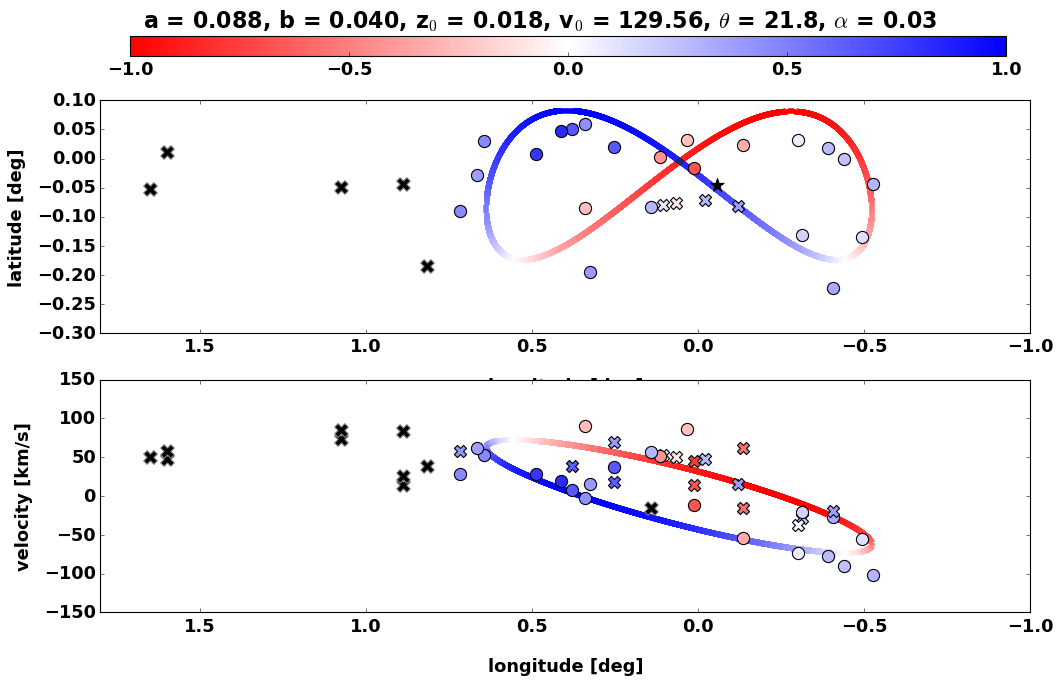

In [406]:
lb_lv_plots_postcolor_grad(Rings_avg, scouse_on=False)



In [ ]:
plot_post_tab_agg[12]

<Row index=12>
cloud_id        A_MC               mu_MC               sigma_MC     
  str3        float64             float64              float64      
-------- ------------------ -------------------- -------------------
      13 3.6079965088955213 -0.10917096702094588 -0.1264811859631931

In [401]:
##convert the cloud posterior sigmas into pc uncertainties for the plotted ones?
cat_sig_list, cat_sig_inner, cat_sig_avg, cat_sig_outer = [], [], [], []
cat_y_list,cat_y_inner,cat_y_avg,cat_y_outer = [], [], [], []

for i in range(len(plot_post_tab_agg[:-3])):
    
    

    lowerlim_y = denorm_yNF_value(plot_post_tab_agg['mu'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab_agg['mu'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab_agg['mu'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = upperlim_y
    
    cat_y_list.append(8.2-combiney_kpc)
    cat_y_inner.append(8.2-lowerlim_y)
    cat_y_avg.append(8.2-avglim_y)
    cat_y_outer.append(8.2-upperlim_y)

    lowerlim_sig_kpc = denorm_sigma_value(abs(plot_post_tab_agg['CI68'][i]/2), Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(abs(plot_post_tab_agg['CI68'][i]/2), Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(abs(plot_post_tab_agg['CI68'][i]/2), Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    #combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    combinesig_kpc = abs(avglim_sig_kpc) + abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))#PDF width + stdv of the three y positions?
    
    cat_sig_list.append(combinesig_kpc)
    cat_sig_inner.append(np.abs(lowerlim_sig_kpc))
    cat_sig_avg.append(np.abs(avglim_sig_kpc))
    cat_sig_outer.append(np.abs(upperlim_sig_kpc))
    

    #print(plot_cat_agg['leaf_id'][i], plot_post_tab_agg['sigma_MC'][i], abs(avglim_sig_kpc) , abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y))))
    print(plot_cat_agg['leaf_id'][i], (8.2-combiney_kpc)*1e3 , (8.2-lowerlim_y)*1e3 ,(8.2-upperlim_y)*1e3, abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))*1e3,abs(avglim_sig_kpc)*1e3,combinesig_kpc*1e3,  )
    #print(plot_cat_agg['leaf_id'][i], (8.2-combiney_kpc)*1e3 , abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))*1e3,  abs(avglim_sig_kpc)*1e3, combinesig_kpc*1e3, plot_post_tab_agg['sigma_MC'][i],abs(avglim_sig_kpc)*1e3,  )

    

1 -36.86702485442517 -9.758389732301254 -36.86702485442517 11.792292337090664 18.568010548812016 30.36030288590268
2 -16.041006585869155 -4.235849892978649 -16.041006585869155 5.138492474069966 17.08949122108037 22.227983695150332
3 -30.694294432773717 -8.121535810856173 -30.694294432773717 9.820136578562192 8.859507063079251 18.679643641641444
4a -42.59389267617841 -11.277012029292877 -42.59389267617841 13.621997810772156 22.859179412528793 36.48117722330095
5 -33.87292679560261 -8.964429715582867 -33.87292679560261 10.835693246890685 9.899004343216884 20.73469759010757
6b -21.78510137661327 -5.759040351840383 -21.78510137661327 6.9736970729548675 8.884593098043934 15.858290170998803
7a -8.347081509704424 -2.1956131465223905 -8.347081509704424 2.6803418027572787 12.723984224836585 15.404326027593862
8a 39.905243514292366 10.59969817265305 39.905243514292366 12.736099547301409 13.835936986969918 26.572036534271327
9 -47.562203114587476 -12.594483855947303 -47.562203114587476 15.2093482

In [402]:
plot_post_tab_agg

<Table length=31>
cloud_id         A          ...         CI68               sigma        
  str3        float64       ...       float64             float64       
-------- ------------------ ... ------------------- --------------------
       1 1.9738715336654222 ...  0.3753286693006973  0.18871018855482902
       2 2.1974021624583373 ...  0.3454422853849802  0.17368371814300293
       3 4.1165960287429435 ... 0.17908364430880896  0.09004083900003448
      4a  1.661719844412958 ...  0.4620691790138636  0.23232214597287418
       5 3.8540320961242838 ... 0.20009575704270194  0.10060544565088297
      6b  4.065013165193719 ... 0.17959072653480046   0.0902957930984196
      7a 2.7616815945525284 ...  0.2571991250627832  0.12931624828224836
      8a  2.135529123536469 ...  0.2796758330245546  0.14061723364385295
       9   5.86237041160961 ...  0.1312086647706891  0.06596994552810755
     ...                ... ...                 ...                  ...
      22  8.495126491300903 ... 0.09212998647701176 0.046321713585118954
      23  4.584218891353628 ... 0.16534065250053498  0.08313104822844519
      24 3.1218249158558495 ...  0.2355752876611436    0.118444074725815
      25 0.6597482669472535 ...  1.1280100115962532   0.5671482074009216
     26a 1.0245372145728158 ...  0.7191056404121701  0.36155660916033716
      27 0.8543369800685139 ...  0.7132177047243347  0.35859623457472317
     28c 0.8459138399343825 ...  0.7149094093493692  0.35944680082473585
     29b 0.8737844701301846 ...   0.798132510174546  0.40129025253360184
     30a 1.1243192053922764 ...  0.6109265316012386  0.30716561350460964
      31 0.9034833123719227 ...  0.7050124234108353   0.3544707298891875

In [403]:
def los_l_to_xyz(l):
    
    rr = np.linspace((8.2--0.21),(8.2-0.21), 100)
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(l),np.deg2rad(0),rr,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    return -y , x

In [391]:
y_offset

np.float64(-0.006612005338255317)

<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\c'
<>:95: SyntaxWarning: invalid escape sequence '\e'
<>:95: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/3723965282.py:95: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/3723965282.py:95: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/3723965282.py:95: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/3723965282.py:95: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long

KeyboardInterrupt: 

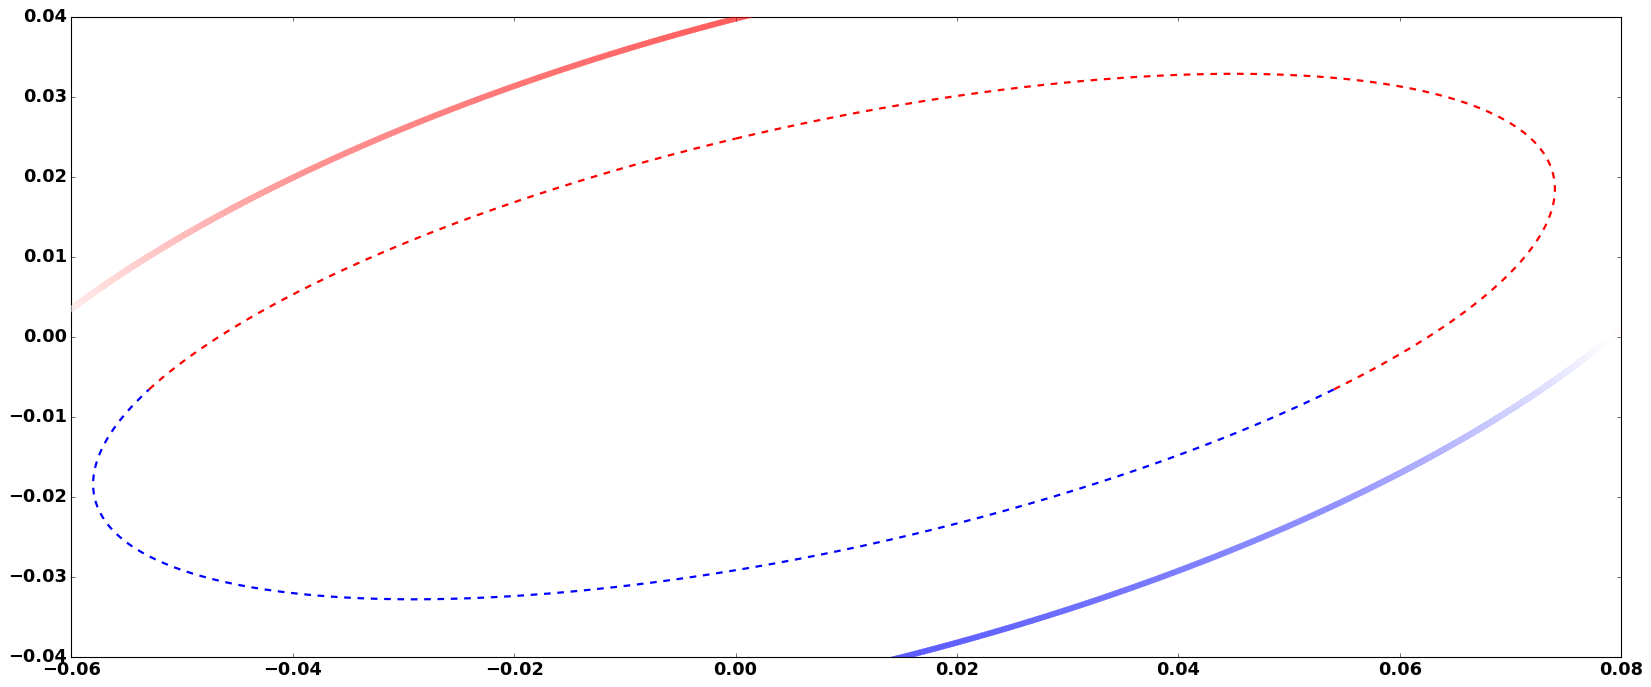

In [411]:
### Another version of top-down with the shaded area
# treating the median ellipse as the average, and the min/max as the most likely ranges possible from the fitting

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag




indind = np.where(Rings_inner.y>y_offset)[0]
indind_xneg = np.where(Rings_inner.x[indind]<0)[0]
indind_xpos = np.where(Rings_inner.x[indind]>0)[0]
sortedind = np.argsort(Rings_inner.x[indind])
inner_fore_ind = np.where(Rings_inner.y<=y_offset)
ax.plot(Rings_inner.x[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],Rings_inner.y[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],'--',c='red',linewidth=2, zorder=10)
ax.plot(Rings_inner.x[indind][indind_xpos],Rings_inner.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_inner.x[inner_fore_ind[0:]],Rings_inner.y[inner_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)

avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)

indind = np.where(Rings_outer.y>y_offset)[0]
indind_xneg = np.where(Rings_outer.x[indind]<0)[0]
indind_xpos = np.where(Rings_outer.x[indind]>0)[0]
sortedind = np.argsort(Rings_outer.x[indind])
outer_fore_ind = np.where(Rings_outer.y<=y_offset)
ax.plot(Rings_outer.x[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],Rings_outer.y[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[indind][indind_xpos],Rings_outer.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=10)
ax.plot(Rings_outer.x[outer_fore_ind[0:]],Rings_outer.y[outer_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)




## Shade between the N and F edges? ##
ax.fill(Rings_outer.x,Rings_outer.y, 'grey', alpha=0.1 ,zorder=0)
ax.fill(Rings_inner.x, Rings_inner.y, 'w', edgecolor='w', alpha=1)





sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-1.5, 1.5, 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=1)
    axt_ticks.append(xline[-1])




divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(len(cat_y_list)):

    if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
        marker = 'X'
        color = 'k'
        alpha = 1.
    else:
        marker = 'o'
        color = plot_post_tab_agg['mu'][i]
        alpha =1.
            
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

    ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)

    ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=9)
    ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , zorder=10) 


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.158, 0.158)

#ax.axes.get_yaxis().set_visible(False)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

ax.set_xlabel('x [pc]', labelpad=20)
ax.set_ylabel('y', labelpad=10)

ax.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
          head_width=0.004*3, head_length=0.005*3, color = 'k')
ax.text(0, -.09, 'To Sun')



#plt.savefig('./paper_items/Figs/x2_fits_topdown_ellipses_shaded.pdf', bbox_inches='tight')


<>:122: SyntaxWarning: invalid escape sequence '\e'
<>:122: SyntaxWarning: invalid escape sequence '\c'
<>:122: SyntaxWarning: invalid escape sequence '\e'
<>:122: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/744346452.py:122: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=40)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/744346452.py:122: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=40)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/744346452.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_97878/744346452.py:105

Text(0.005, -0.125, 'To Sun')

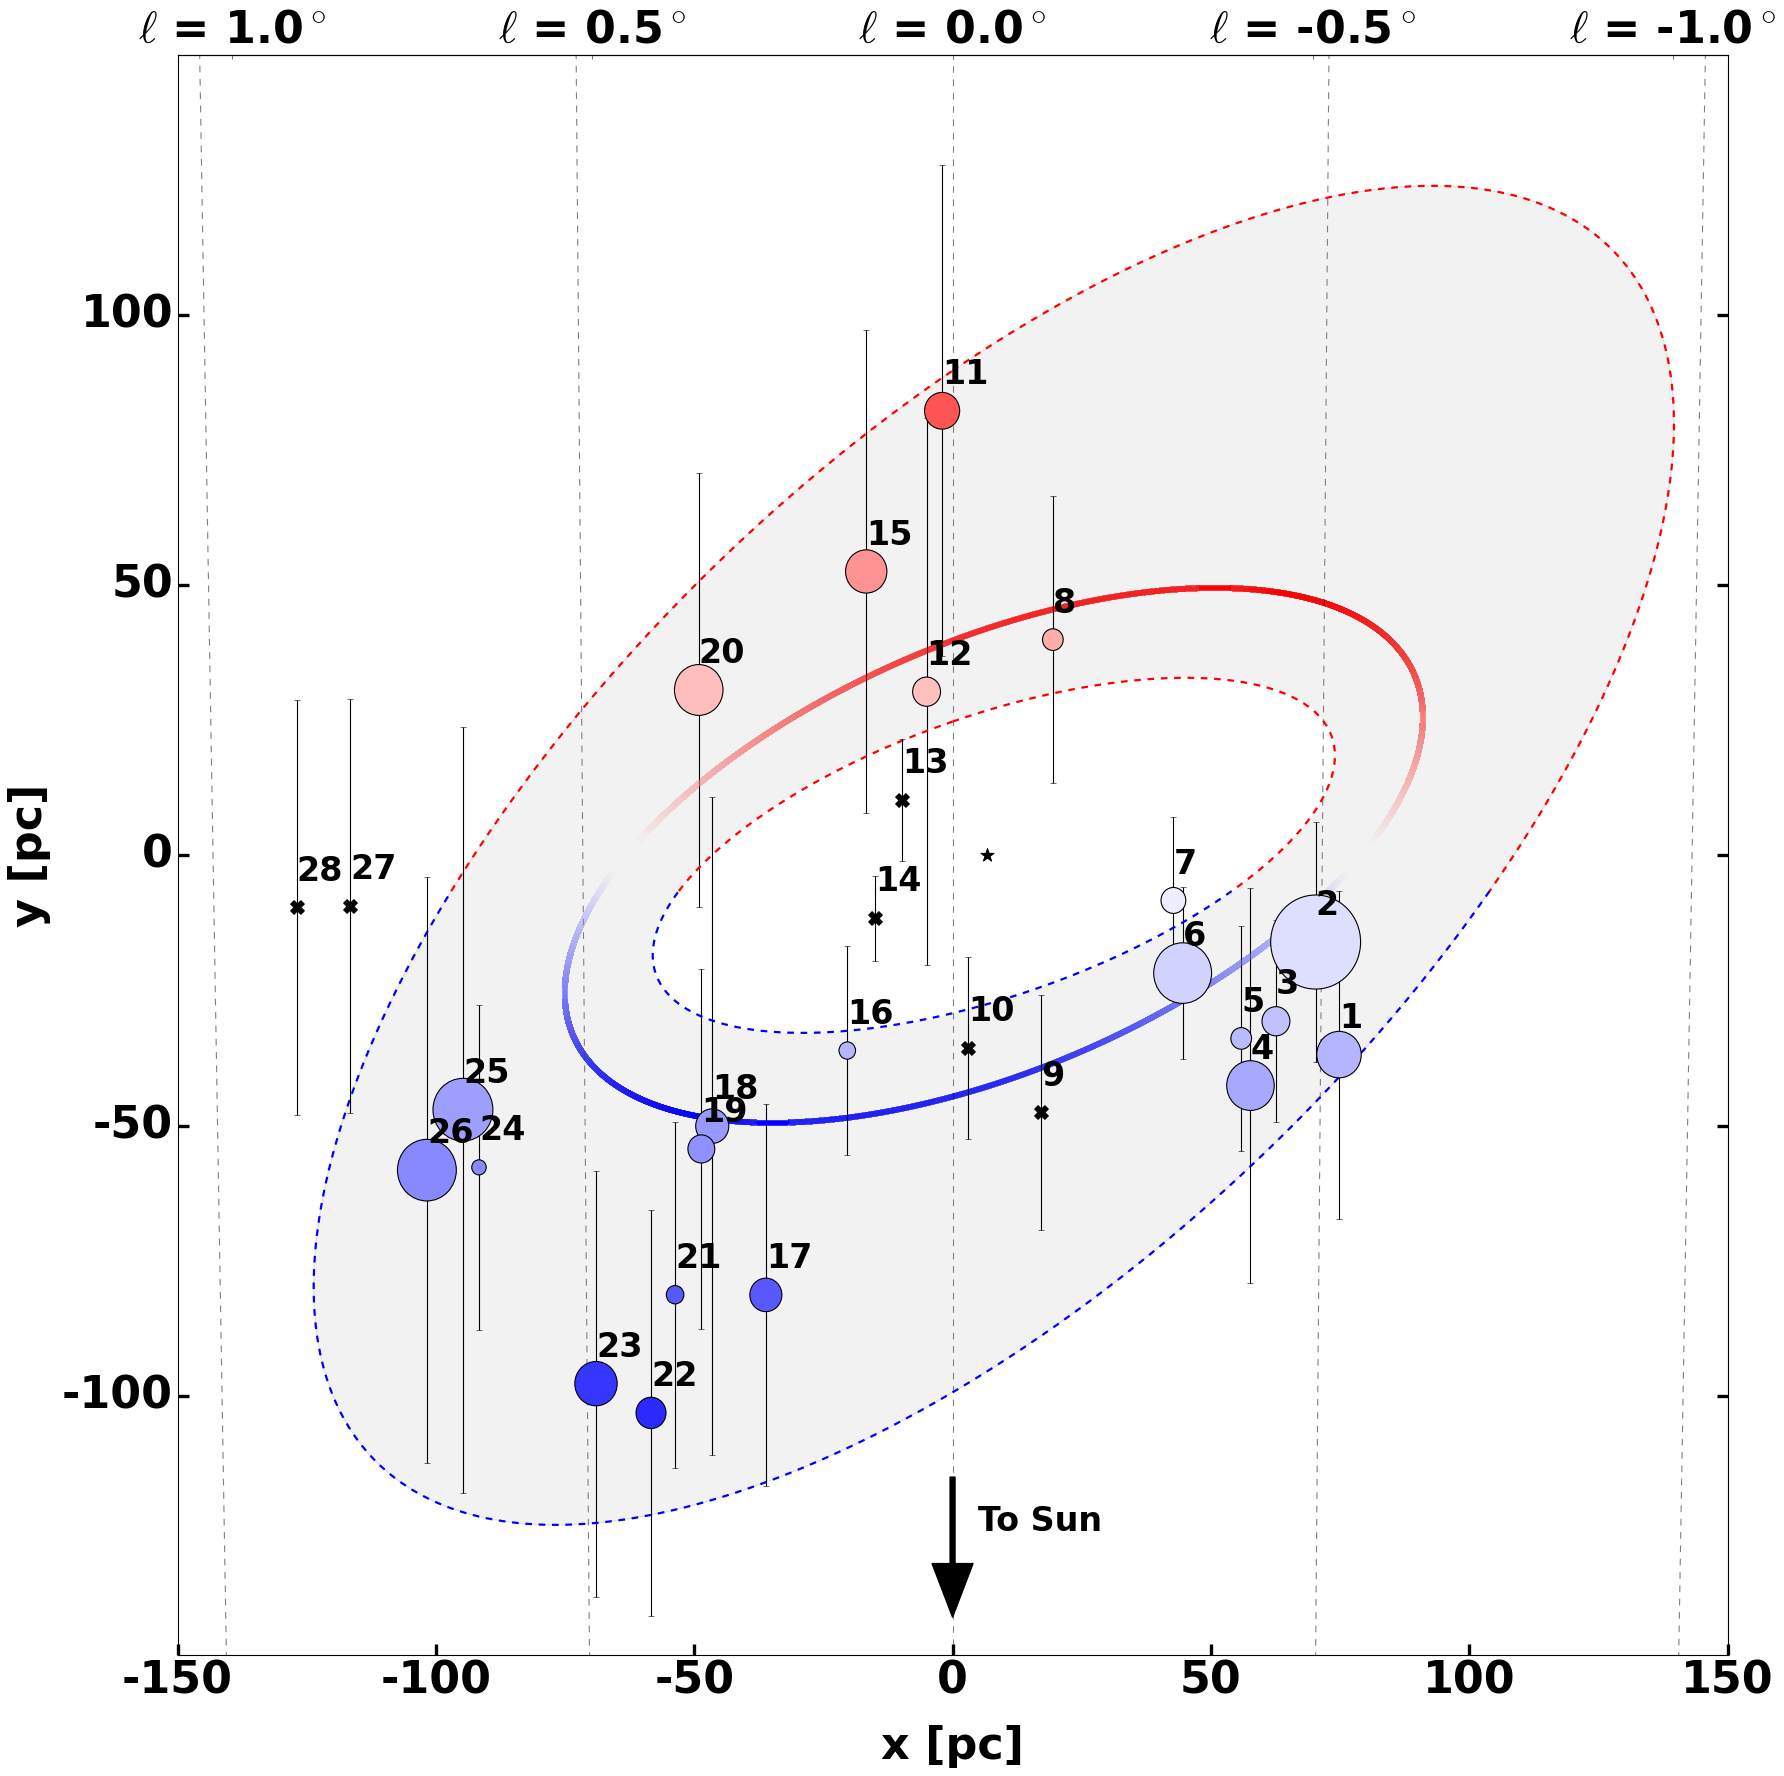

In [429]:
### Another version of top-down with the shaded area
### ADDING IN THE FACE-ON PROJECTED AREAS
# treating the median ellipse as the average, and the min/max as the most likely ranges possible from the fitting


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag




indind = np.where(Rings_inner.y>y_offset)[0]
indind_xneg = np.where(Rings_inner.x[indind]<0)[0]
indind_xpos = np.where(Rings_inner.x[indind]>0)[0]
sortedind = np.argsort(Rings_inner.x[indind])
inner_fore_ind = np.where(Rings_inner.y<=y_offset)
ax.plot(Rings_inner.x[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],Rings_inner.y[indind][indind_xneg][np.argsort(Rings_inner.x[indind][indind_xneg])],'--',c='red',linewidth=2, zorder=9)
ax.plot(Rings_inner.x[indind][indind_xpos],Rings_inner.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=9)
ax.plot(Rings_inner.x[inner_fore_ind[0:]],Rings_inner.y[inner_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)

avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=9)

indind = np.where(Rings_outer.y>y_offset)[0]
indind_xneg = np.where(Rings_outer.x[indind]<0)[0]
indind_xpos = np.where(Rings_outer.x[indind]>0)[0]
sortedind = np.argsort(Rings_outer.x[indind])
outer_fore_ind = np.where(Rings_outer.y<=y_offset)
ax.plot(Rings_outer.x[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],Rings_outer.y[indind][indind_xneg][np.argsort(Rings_outer.x[indind][indind_xneg])],'--',linewidth=2,c='red',zorder=9)
ax.plot(Rings_outer.x[indind][indind_xpos],Rings_outer.y[indind][indind_xpos],'--',linewidth=2,c='red',zorder=9)
ax.plot(Rings_outer.x[outer_fore_ind[0:]],Rings_outer.y[outer_fore_ind[0:]],c='blue', linestyle = '--', linewidth=2, zorder=9)




## Shade between the N and F edges? ##
ax.fill(Rings_outer.x,Rings_outer.y, 'grey', alpha=0.1 ,zorder=0)
ax.fill(Rings_inner.x, Rings_inner.y, 'w', edgecolor='w', alpha=1)





sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-2., 2., 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=1)
    axt_ticks.append(xline[-1])




divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
cmap    = 'bwr_r'
for i in range(len(cat_y_list)):
    

    if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
        marker = 'X'
        color = 'k'
        alpha = 1.

        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
        ax.scatter(-y,cat_y_list[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)
        ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=9)
        ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) ,fontsize=30, zorder=10) 

    else:

        circle_rad = plot_cat_agg['rad'][i]/1e3 #in kpc
        
        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

        circle = mpl.patches.Circle((-y,cat_y_list[i]), radius=circle_rad)
        circle.set_zorder(10)
        color = cm.bwr_r(divnorm(plot_post_tab_agg['mu'][i]))
        alpha =1.

        ax.add_artist(circle, )
        circle.set_facecolor(color)
        circle.set_zorder(9)
        ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], c='k', zorder=8)
        ax.text((-y),cat_y_list[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , fontsize=30, zorder=10) 


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.148, 0.148)

#ax.axes.get_yaxis().set_visible(False)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels, fontsize=40)
ax.set_yticklabels(ylabels, fontsize=40)

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax.tick_params(axis='x', # Specify the x-axis
               which='major', # Apply to major ticks
               top = False,
               length=10, # Set tick mark length to 10 points
               width=3) # Set tick mark width to 2 points

ax.tick_params(axis='y', # Specify the x-axis
               which='major', # Apply to major ticks
               length=10, # Set tick mark length to 10 points
               width=3) # Set tick mark width to 2 points


ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list],fontsize=40)

ax.set_xlabel('x [pc]', labelpad=20,fontsize=40)
ax.set_ylabel('y [pc]', labelpad=10,fontsize=40)

ax.arrow(0.0, -.115, 0, -0.008*2, length_includes_head=False,
          head_width=0.004*2, head_length=0.005*2, color = 'k')
ax.text(0.005, -.125, 'To Sun', fontsize=30,zorder=10)



#plt.savefig('./paper_items/Figs/x2_fits_topdown_ellipses_shaded_circleareas.pdf', bbox_inches='tight')


array([     0,      1,      2, ..., 191189, 191190, 191191],
      shape=(71738,))

# Separate top-down ellipses! 

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25*2.5), dpi=300)
plt.subplots_adjust(wspace=0.05)
fig.set_facecolor('white')
fig.set_facecolor('white')

ringcmap = 'bwr_r' #cmr.prinsenvlag


### Plot Rings LB ###
min_ringcolor = ring_NF_dist(Rings_inner)[2]
min_lines = colored_line(Rings_inner.x ,Rings_inner.y , min_ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=10)


avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=10)


max_ringcolor = ring_NF_dist(Rings_outer)[2]
max_lines = colored_line(Rings_outer.x ,Rings_outer.y , max_ringcolor, ax[2], linewidth=5, cmap=ringcmap,zorder=10)

ax[0].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)
ax[1].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)
ax[2].scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


for axes in ax:
    long_list = np.arange(-1.5, 1.5, 0.5)
    axt_ticks = []
    for ll in long_list:
        xline, rrline = los_l_to_xyz(ll)
        axes.plot(xline, rrline , linestyle = '--', c='gray',zorder=0)
        axt_ticks.append(xline[-1])

    axes.set_xlim(-0.15, 0.15)
    axes.set_ylim(-0.158, 0.158)
    xlabels = [item.get_text().replace('\u2212', '-') for item in axes.get_xticklabels()]
    xlabels = [str(int(float(item)*1e3)) for item in xlabels]
    ylabels = [item.get_text().replace('\u2212', '-') for item in axes.get_yticklabels()]
    ylabels = [str(int(float(item)*1e3)) for item in ylabels]
    axes.set_xticklabels(xlabels)
    axes.set_yticklabels(' ')

    ax_t = axes.secondary_xaxis('top') #set top axis ticks on
    ax_t.set_xticks(axt_ticks)
    ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

    axes.set_xlabel('x [pc]', labelpad=20)
    axes.set_ylabel('y', labelpad=10)

    axes.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
            head_width=0.004*3, head_length=0.005*3, color = 'k')
    axes.text(-.127, -.09, 'To Sun')

    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    cmap    = 'bwr_r'

    if axes == ax[0]:
        ycatsig, ycat   = cat_sig_inner, cat_y_inner
    if axes == ax[1]:
        ycatsig, ycat  = cat_sig_avg, cat_y_avg
    if axes == ax[2]:
        ycatsig, ycat = cat_sig_outer, cat_y_outer

    for i in range(len(ycat)):

        if plot_post_tab_agg['cloud_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            color = 'k'
            alpha = 1.
        else:
            marker = 'o'
            color = plot_post_tab_agg['mu_MC'][i]
            alpha =1.
                
        x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),ycat[i]+8.2,
                        0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)

        axes.scatter(-y,ycat[i], marker = marker, c=color , cmap=cmap, norm=divnorm, s = 150, zorder = 10)

        axes.errorbar(-y,ycat[i], yerr=ycatsig[i], c='k', zorder=9)
        axes.text((-y),ycat[i]+0.005, int(''.join(filter(str.isdigit, plot_cat_agg['leaf_id'][i]))) , zorder=10) 


plt.savefig('./paper_items/Figs/separate_x2_fits_topdown_ellipses.pdf', bbox_inches='tight')


<>:45: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\c'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:45: SyntaxWarning: invalid escape sequence '\e'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:45: SyntaxWarning: invalid escape sequence '\c'
  ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(xlabels)
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_98961/3111368887.py:41: UserWarning: set_ticklabels() should only be used with a fixed numbe

In [ ]:
cat_tab

<Table length=22>
leaf_id   cloud_name      l       b    ... NF_decision absorp_NF lb_pixel_mask
  str3      str14      float64 float64 ...     str3       str3       int64    
------- -------------- ------- ------- ... ----------- --------- -------------
      1 G359.475-0.044  -0.525  -0.044 ...          LN       nan             1
      2 G359.508-0.135  -0.492  -0.135 ...           N       nan             1
      3 G359.561-0.001  -0.439  -0.001 ...           U         F             1
     4a G359.595-0.223  -0.405  -0.223 ...           N       nan             1
      5 G359.608+0.018  -0.392   0.018 ...          LN         N             1
     6b G359.688-0.132  -0.312  -0.132 ...           U         F             1
     7a G359.701+0.032  -0.299   0.032 ...          LN         N             1
     8a G359.865+0.023  -0.135   0.023 ...           F         F             1
    11a   G0.014-0.016   0.014  -0.016 ...           F       nan             1
    ...            ...     ...     ... ...         ...       ...           ...
    17b    G0.255+0.02   0.255    0.02 ...           N         N             1
     18   G0.327-0.195   0.327  -0.195 ...           U       nan             1
     19    G0.342+0.06   0.342    0.06 ...           N         N             1
     20   G0.342-0.085   0.342  -0.085 ...           F         F             1
    21a    G0.379+0.05   0.379    0.05 ...           N         N             1
     22   G0.413+0.048   0.413   0.048 ...           N         N             1
     23   G0.488+0.008   0.488   0.008 ...           N         N             1
     24    G0.645+0.03   0.645    0.03 ...           N       nan             1
     25   G0.666-0.028   0.666  -0.028 ...           U         N             1
    26a    G0.716-0.09   0.716   -0.09 ...           N       nan             1

In [ ]:
np.array(xray_tab['cloud_index']).astype(str)

array(['13', '14'], dtype='<U21')

# Save LOS dist results to Table

In [ ]:
##Load in PPDF table and create a column that lists the methods used##
PPDF_meth_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/paper_items/Tables/PPDF_method_info.tex")
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")
xray_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/xray_methods.tex")
nogueras_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/nogueras_measures.tex")

method_col = []
for i in range(len(PPDF_meth_tab)):
    meths = np.array('')
    j = PPDF_meth_tab[i]['leaf_id']
    
    if np.isnan(PPDF_meth_tab[i]['flux_diff']) == False:
        meths= meths + 'd'
    if np.isnan(PPDF_meth_tab[i]['flux_ratio']) == False:
        meths = meths + ',r'
    if np.isnan(PPDF_meth_tab[i]['corr_coeff']) == False:
        meths = meths + ',c'
    if np.isnan(PPDF_meth_tab[i]['absorp_value']) == False:
        meths = meths + ',a'
    if np.isnan(starcount_tab[i]['counts_ratio_from_avg']) == False:
        meths = meths + ',s'
    if j in np.array(xray_tab['cloud_index']).astype(str):
        meths = meths + ',x'
    if j in np.array(nogueras_tab['cloud_index']).astype(str):
        meths = meths + ',k'
    
    method_col.append(meths)
meth_table = Table()
meth_table['leaf_id'] = PPDF_meth_tab['leaf_id']
meth_table['methods'] = method_col
meth_table

<Table length=47>
leaf_id  methods 
  str3     str9  
------- ---------
      1   d,r,c,s
      2   d,r,c,s
      3 d,r,c,a,s
     4a   d,r,c,s
     4b   d,r,c,s
      5 d,r,c,a,s
     6a d,r,c,a,s
     6b d,r,c,a,s
     7a d,r,c,a,s
    ...       ...
    26b   d,r,c,s
     27   d,r,c,s
    28a   d,r,c,s
    28b   d,r,c,s
    28c   d,r,c,s
    29a   d,r,c,s
    29b   d,r,c,s
    30a   d,r,c,s
    30b   d,r,c,s
     31   d,r,c,s

In [ ]:
##convert the cloud posterior sigmas into pc uncertainties for ALL IDs

full_cat_sig_list = []
full_cat_y_list = []
for i in range(len(plot_post_tab[:])):

    lowerlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = avglim_y
    
    cat_y_list.append(8.2-combiney_kpc)
    cat_y_inner.append(8.2-lowerlim_y)
    cat_y_avg.append(8.2-avglim_y)
    cat_y_outer.append(8.2-upperlim_y)
    
    full_cat_y_list.append(8.2-combiney_kpc)   
    
    lowerlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(plot_post_tab['sigma_MC'][i], Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    #combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    combinesig_kpc = abs(avglim_sig_kpc) + abs(np.std((8.2-lowerlim_y, 8.2-upperlim_y, 8.2-avglim_y)))#PDF width + stdv of the three y positions?
    
    cat_sig_list.append(combinesig_kpc)
    cat_sig_inner.append(np.abs(lowerlim_sig_kpc))
    cat_sig_avg.append(np.abs(avglim_sig_kpc))
    cat_sig_outer.append(np.abs(upperlim_sig_kpc))
    full_cat_sig_list.append(combinesig_kpc)
    

    
    print(plot_tab['leaf_id'][i], (8.2-combiney_kpc)*1e3 , combinesig_kpc*1e3 )
    
los_table = Table()
los_table['leaf id'] = plot_tab['leaf_id']
los_table['cloud name'] = plot_tab['cloud_name']
los_table['l'] = plot_tab['l'] * u.degree
los_table['b'] = plot_tab['b'] * u.degree
los_table['v'] = plot_tab['v'] * u.km/ u.s
los_table['A_mc']      = plot_post_tab['A_MC'].round(3)
los_table['mu_mc']     = plot_post_tab['mu_MC'].round(3)
los_table['sigma_mc']  = abs(plot_post_tab['sigma_MC'].round(3))
los_table['LOS_pos'] = np.round(np.array(full_cat_y_list), 3) * u.kpc
los_table['LOS_sig'] = np.round(np.array(full_cat_sig_list), 3) * u.kpc
los_table['NF Methods'] = meth_table['methods']
los_table.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/paper_items/Tables/LOS_synth_table.tex", format = 'latex', overwrite=True)


1 -38.32860080547995 63.70715498490376
2 -16.397974818882943 51.90464317713981
3 -32.41371114632052 36.046394016368275
4a -44.231667316889656 77.4980597858438
4b -49.210285142143206 101.60583439249552
5 -35.63744388245915 38.405133141766896
6a -26.59957121346679 37.899263627563585
6b -24.806063973048964 31.604139907003947
7a -7.914198537488204 36.13638414128257
7b -0.5580423009927671 36.655931435598575
8a 39.959715642716276 48.05177734075825
8b 74.40518121372541 52.26719402801379
8c 75.82396207170738 67.56479367920376
9 -54.077728633291855 53.84269681587854
10 -41.34570460012199 100.52749629937067
11a 85.70339316018938 79.25880100746532
11b 103.16387348596123 87.2765642299663
11c 87.33136379195017 53.07155215868615
12 32.13316889065787 96.4964205764895
13 14.092857995951391 37.6282836261662
14 -18.767003630271617 15.803467826372586
15 58.95463235801124 94.37355453971561
16a nan nan
16b -37.106132648371926 35.902743082437645
17a -80.3108653754343 48.40160417503134
17b -83.12241206583693

In [ ]:
los_table[19:28]

<Table length=9>
leaf id  cloud name     l       b    ... sigma_mc LOS_pos LOS_sig NF Methods
                       deg     deg   ...            kpc     kpc             
  str3     str14     float64 float64 ... float64  float64 float64    str9   
------- ------------ ------- ------- ... -------- ------- ------- ----------
     13 G0.068-0.076   0.068  -0.076 ...    0.126   0.014   0.038  d,r,c,a,x
     14  G0.105-0.08   0.105   -0.08 ...    0.036  -0.019   0.016  d,r,c,a,x
     15 G0.116+0.003   0.116   0.003 ...    0.286   0.059   0.094  d,r,c,a,s
    16a G0.143-0.083   0.143  -0.083 ...      nan     nan     nan           
    16b G0.143-0.083   0.143  -0.083 ...    0.089  -0.037   0.036  d,r,c,a,s
    17a  G0.255+0.02   0.255    0.02 ...    0.081   -0.08   0.048  d,r,c,a,s
    17b  G0.255+0.02   0.255    0.02 ...    0.087  -0.083   0.051  d,r,c,a,s
    17c  G0.255+0.02   0.255    0.02 ...     0.05  -0.052   0.031  d,r,c,a,s
     18 G0.327-0.195   0.327  -0.195 ...     0.53  -0.052   0.155    d,r,c,s

In [ ]:
Rings_out_tab = ascii.read("Rings_out.dat")

def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Positive values are on the NEAR SIDE in front of SgrA*
    Negative values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out_tab['r']) - np.nanmin(Rings_out_tab['r']))
    
    real_y = (term1*term2) + np.nanmin(Rings_out_tab['r'])

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2]
#normELL_l, normELL_b, normELL_v = normalizelbv(Rings_out.l,Rings_out.b,Rings_out.vr)
#back_ind, fore_ind, y_NF = ring_NF_dist(Rings_out) #finds the N/F on the ellipse
#Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

# Try fitting different initial CMZ sizes (change by 5 pc each time?)

params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       #b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': -180, 'max': 180, 'vary': True},
                       #alpha_rings={'value': 0.4  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )
params.add('b_rings', value=0.61*params['a_rings'].value, min=0.01, max=0.2, vary=True)
params.add('alpha_rings', value=0.3904+(((params['a_rings'].value-0.010)/0.005)*0.0006), min= -np.pi/2, max= np.pi/2, vary=True)

#params.add('b_rings', value=0.055, min=0.01, max=0.2, vary=True)

out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))



In [441]:
agrid = np.arange(10, 305, 5)
bgrid = np.arange(10, 305, 5)

grid_tab = Table()
r0, a_out, b_out, z_out, v_out, theta_out, alpha_out, redchisq = [], [], [], [], [], [],[], []

for i in range(len(agrid)):
    print(agrid[i],bgrid[i])

    params_GRID = create_params(a_rings={'value': agrid[i]/1e3   , 'min': 0.01, 'max': 0.3, 'vary': True},
                               b_rings={'value': (0.61*agrid[i])/1e3  , 'min': 0.01, 'max': 0.2, 'vary': True},
                               z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                               v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                               theta_rings={'value': 25  , 'min': -180, 'max': 180, 'vary': True},
                               #alpha_rings={'value': 0.3904+((((agrid[i]/1e3)-0.010)/0.005)*0.0006)  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': True},
                               alpha_rings={'value': 0.4  , 'min': -np.pi/2, 'max': np.pi/2, 'vary': True},
                               ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                                  )
    
    out = minimize(ring_resid, params_GRID, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))
    print(fit_report(out))
        
    #if (np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[1]])<np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[0]])):
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

    Rings_out = Ring(phi,
                      out.params['a_rings'].value,
                      out.params['b_rings'].value,
                      out.params['z_rings'].value,
                      out.params['v_rings'].value, 
                      np.radians(out.params['theta_rings'].value),
                      xyzsun,vxyzsun,
                      out.params['alpha_rings'].value)


#    N_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#    F_cent_vr = Rings_out.vr[argmedian(np.degrees(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
    NN = np.where(ring_NF_dist(Rings_out)[2]==1)
    FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

    print(Rings_out.vr[NN], Rings_out.vr[FF])

    print(np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]) , ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF])

#    N_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[1][0]]
#    N_cent_vr = Rings_out.vr[argmedian(N_rings_arr[np.where((np.degrees(N_rings_arr)>0) )[0]])]

#    F_rings_arr = Rings_out.l[ring_NF_dist(Rings_out)[0][0]]
#    F_cent_vr = Rings_out.vr[argmedian(F_rings_arr[np.where((np.degrees(F_rings_arr)>0.) )[0]])]
    if (Rings_out.vr[NN]<Rings_out.vr[FF]) and (out.params['a_rings']>=out.params['b_rings']):
        print("NICE FIT!")
        lb_lv_plots_postcolor_grad(Rings_out, out)
        
        r0.append(agrid[i])
        a_out.append(out.params['a_rings'].value)
        b_out.append(out.params['b_rings'].value)
        z_out.append(out.params['z_rings'].value)
        v_out.append(out.params['v_rings'].value)
        theta_out.append(out.params['theta_rings'].value)
        alpha_out.append(out.params['alpha_rings'].value)
        redchisq.append(out.redchi)
    else:
        print("DISREGARDED FIT")
        lb_lv_plots_postcolor_grad(Rings_out, out)

10 10
0.01 0.01 0.0125 130.0 25.0 0.40000000000000013 0.08814331359146287 3.3658350791161675
0.010446986608696446 0.01 0.0125 130.0 25.0 0.40000000000000013 0.08814487731772322 3.3032514398733905
XXXXX 0.01 0.010292853295352844 0.0125 1.0292853295352844 0.08814350766139004 3.4487391612927687
0.01 0.01 0.01193753588210128 130.0 25.0 0.40000000000000013 0.08723697584348736 3.369797122261399
0.01 0.01 0.0125 130.24635451043287 25.0 0.40000000000000013 0.08814331359146287 3.3701832080243905
0.01 0.01 0.0125 130.0 26.24128296079965 0.40000000000000013 0.08814486435818895 3.3893392143686185
0.01 0.01 0.0125 130.0 25.0 0.4195223600830269 0.08814260844384403 3.3580179957618324
XXXXX 0.010049687878544197 0.010292853295352844 0.012311540925982401 1.0241963153231652 0.08775500184339372 3.446082122645263
XXXXX 0.010027950130100601 0.010073241557131324 0.01235856566555039 1.0045165189737804 0.08783460904500709 3.3891279114108745
0.010077634815926976 0.010008138880469334 0.012264576578978956 130.102

KeyboardInterrupt: 

In [ ]:
#N_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
#F_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
NN = np.where(ring_NF_dist(Rings_out)[2]==1)
FF = np.where(ring_NF_dist(Rings_out)[2]==-1)

print(Rings_out.vr[NN], Rings_out.vr[FF])
np.degrees(Rings_out.l[NN]), np.degrees(Rings_out.l[FF]), ring_NF_dist(Rings_out)[2][NN], ring_NF_dist(Rings_out)[2][FF]

[-0.00129442] [-0.02049355]


(array([-0.17797083]), array([0.2909941]), array([1.]), array([-1.]))

In [ ]:
Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])], Rings_out.vr[np.argmin(ring_NF_dist(Rings_out)[2])]
ring_NF_dist(Rings_out)[0][0]

array([     0,      1,      2, ..., 359997, 359998, 359999],
      shape=(180927,))

# Chisq Plots

0.06962127406019994 0.08836672197255739 0.16422777559666873
0.025600625339555635 0.040261274582288585 0.07624559234377357
0.017632826462503352 0.01832836894063177 0.018761548343126044
131.94230753091114 129.58582996287535 115.15670841107882
18.331998592100252 21.77173191202013 46.28693280317741
-0.0571549778278888 0.03316749429531529 0.04725866493156479


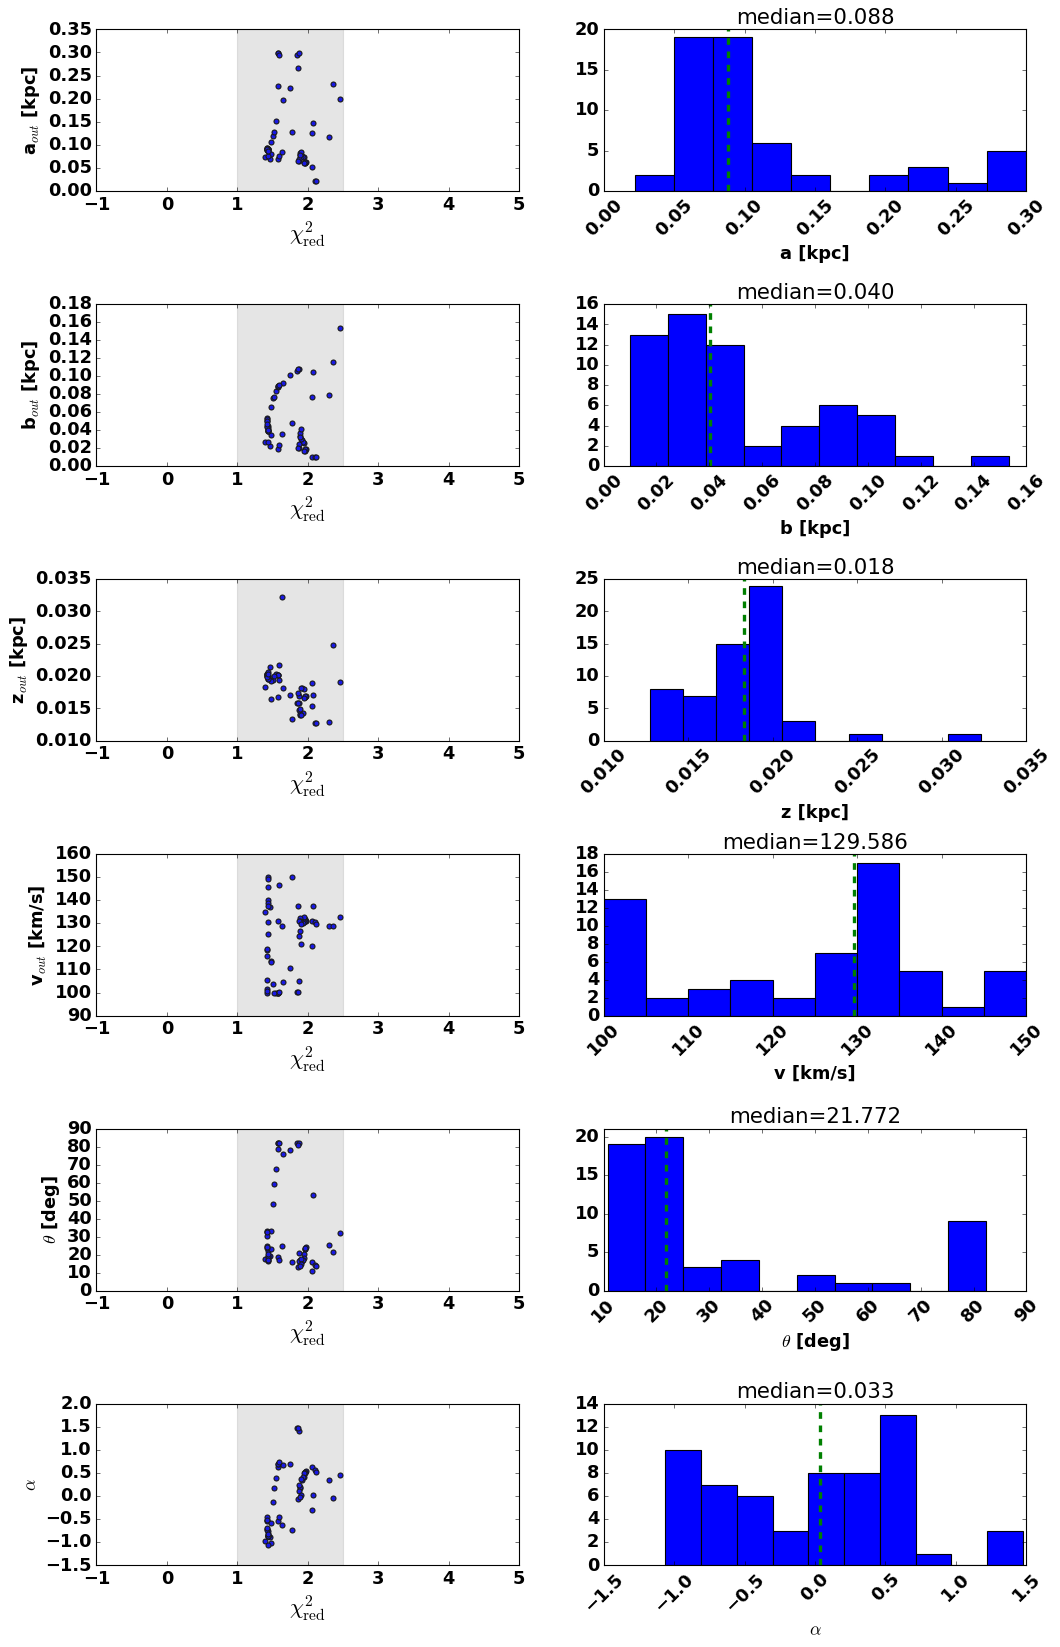

In [397]:
fig, ax = plt.subplots(6, 2,  figsize=(15, 24))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.7)

output_params = [a_out, b_out, z_out, v_out, theta_out, alpha_out]
output_param_name = ['a [kpc]', 'b [kpc]', 'z [kpc]', 'v [km/s]', r'$\theta$ [deg]', r'$\alpha$']

# Define redchisq bin masks
redchisq = np.asarray(redchisq)  # ensure it's a NumPy array
bins = [
    #(redchisq <= 12),                          # 10–12
    (redchisq > 1) & (redchisq <= 2.5),        # 12–14
    
]
bin_labels = [
    #'10 < redchisq < 12',
    '1 < redchisq < 3',
    #'14 < redchisq < 16'
]


ax[0][0].scatter(redchisq, a_out)
ax[1][0].scatter(redchisq, b_out)
ax[2][0].scatter(redchisq, z_out)
ax[3][0].scatter(redchisq, v_out)
ax[4][0].scatter(redchisq, theta_out)
ax[5][0].scatter(redchisq, alpha_out)


ax[0][0].set_ylabel(r'a$_{out}$ [kpc]')
ax[1][0].set_ylabel(r'b$_{out}$ [kpc]')
ax[2][0].set_ylabel(r'z$_{out}$ [kpc]')
ax[3][0].set_ylabel(r'v$_{out}$ [km/s]')
ax[4][0].set_ylabel(r'$\theta$ [deg]')
ax[5][0].set_ylabel(r'$\alpha$')

for axes in ax:

    axes[:][0].set_xlabel(r'$\chi_{\mathrm{red}}^{2}$', fontsize=20)
    #axes[:][0].axvspan(1, 3, alpha=0.2, color='grey',zorder=1)
    axes[:][0].axvspan(1, 2.5, alpha=0.2, color='grey',zorder=1)


# Loop through each parameter (rows)
for i in range(len(output_params)):


    param_array = np.asarray(output_params[i])
    mask = bins[0]
    mask_large_ell = (a_out > np.median(a_out))
    mask_small_ell = (a_out < np.median(a_out))
    hist_vals = param_array[mask]
        
    #h = ax[i][1].hist(hist_vals, bins=int(np.sqrt(len(hist_vals))))
    h = ax[i][1].hist(hist_vals, bins=10)

    median_val = np.median(hist_vals)
    print(np.mean(hist_vals[mask_small_ell]), median_val, np.mean(hist_vals[mask_large_ell]) )

    
    
    ax[i][0].set_xlim(-1, 5)
    ax[i][1].axvline(median_val, color='g', linestyle='dashed', linewidth=3)
    ax[i][1].set_ylim(0, h[0].max() + 1)
    ax[i][1].set_title(f'median={median_val:.3f}')
    ax[i][1].set_xlabel(f'{output_param_name[i]}')
    ax[i][1].tick_params(axis='x', labelrotation=45)
#plt.savefig('./paper_items/Figs/redchisq_converge.pdf', bbox_inches='tight')

In [375]:
# Locations of the bin edges 
from scipy import stats
print('bins =', (len(hist_vals)))
print('bins =', int(np.sqrt(len(hist_vals))))
for i in range(len(output_params)):


    param_array = np.asarray(output_params[i])
    mask = bins[0]
    hist_vals = param_array[mask]

    h, bedges = np.histogram(hist_vals, bins='auto')
    print(bedges[0],np.median(hist_vals), bedges[-1], 3*stats.sem(hist_vals))

bins = 59
bins = 7
0.022129942886714472 0.08836672197255739 0.2995362731017055 0.028817616962054433
0.010000831832981725 0.040261274582288585 0.15328765844313616 0.012833878779425482
0.012752721938029416 0.01832836894063177 0.03229924199970381 0.0012427394838712327
100.00007539718023 129.58582996287535 149.9816093668248 5.9647237889731395
10.734899684651566 21.77173191202013 82.33760857412835 9.104378169179423
-1.0611842724672826 0.03316749429531529 1.473903203181544 0.2616293358750234


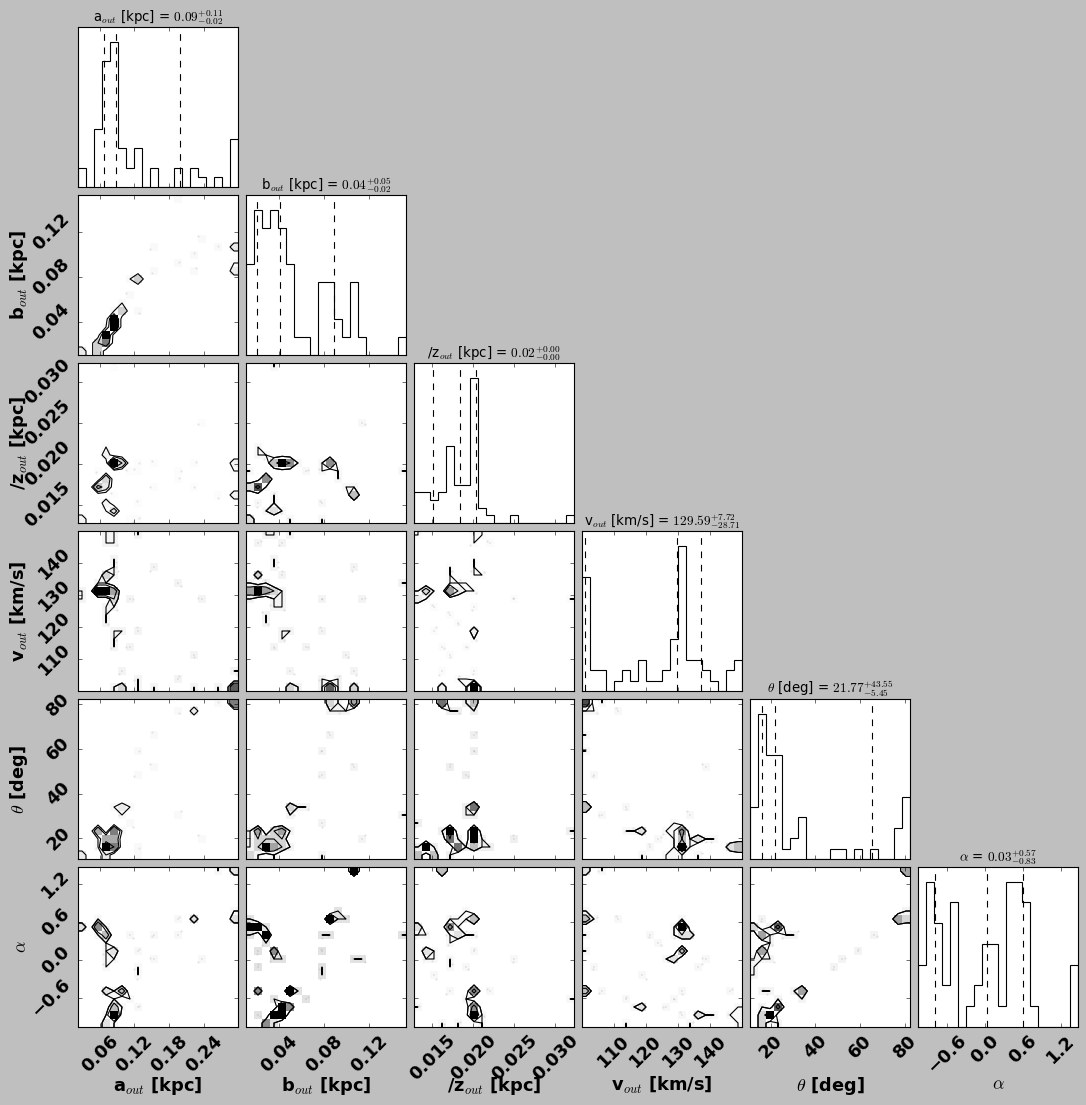

In [203]:
import corner


output_params = [a_out, b_out, z_out, v_out, theta_out, alpha_out]
output_param_name = ['a [kpc]', 'b [kpc]', 'z [kpc]', 'v [km/s]', r'$\theta$ [deg]', r'$\alpha$']

# Define redchisq bin masks
redchisq = np.asarray(redchisq)  # ensure it's a NumPy array
bins = [
    #(redchisq <= 12),                          # 10–12
    (redchisq > 1) & (redchisq <= 3),        # 12–14
    #(redchisq > 14) & (redchisq <= 16)         # 14–16
]
bin_labels = [
    #'10 < redchisq < 12',
    '1 < redchisq < 3',
    #'14 < redchisq < 16'
]


figure = corner.corner(
    np.asarray(output_params).T,
    labels=[
        r'a$_{out}$ [kpc]',
        r'b$_{out}$ [kpc]',
        r'/z$_{out}$ [kpc]',
        r'v$_{out}$ [km/s]',
        r'$\theta$ [deg]',
        r'$\alpha$'
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

